Initial State: (0, {'prob': 1})
Action Space: Discrete(4)
Observation Space: Discrete(16)
Grid shape (rows, cols): (5, 5)
Reward range: (0, 1)

SFFF
FHFH
FFFH
HFFG

Manual policy shape: (16, 4)
Example row for state 0: [0. 0. 1. 0.]
Value function after policy evaluation:
[[0.032 0.024 0.048 0.   ]
 [0.039 0.    0.095 0.   ]
 [0.086 0.219 0.238 0.   ]
 [0.    0.419 0.619 0.   ]]


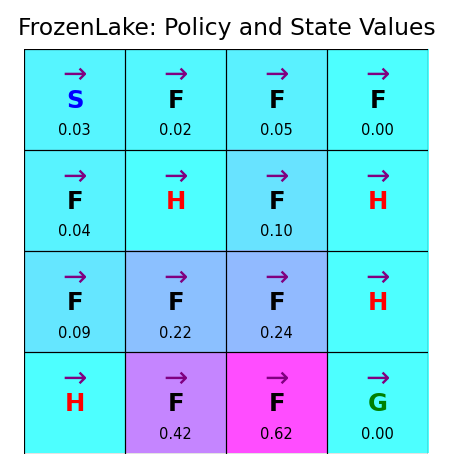

In [25]:
##policy_evaluation uses Bellman expectation to compute V(s) for that mannual policy.
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

env=gym.make('FrozenLake-v1',render_mode='ansi')
state=env.reset()

print("Initial State:",state)
print("Action Space:",env.action_space)
print("Observation Space:",env.observation_space)
print("Grid shape (rows, cols):",(5,5))
print("Reward range:",(min({r for s in env.unwrapped.P for a in env.unwrapped.P[s] for (_,_,r,_) in env.unwrapped.P[s][a]}),max({r for s in env.unwrapped.P for a in env.unwrapped.P[s] for (_,_,r,_) in env.unwrapped.P[s][a]})))

obs, info = env.reset(seed=42)
frame = env.render()  # returns ANSI text since render_mode='ansi'
print(frame)

gamma=0.99
theta=1e-8
V=np.zeros(env.observation_space.n)

P=env.unwrapped.P
nS=env.observation_space.n    # number of states
nA=env.action_space.n
manual_policy=np.zeros((nS,nA))
manual_policy[:,2]=1.0          # action 2 = RIGHT, prob=1 for all states

def plot(V,policy,col_ramp=1,dpi=175,draw_vals=False):

   # Visualize FrozenLake state values V and policy arrows.

    plt.rcParams['figure.dpi']=dpi
    plt.rcParams.update({'axes.edgecolor':(0.32,0.36,0.38)})
    plt.rcParams.update({'font.size':6 if env.unwrapped.nrow==8 else 8})
    plt.figure(figsize=(3,3))

    desc=env.unwrapped.desc
    nrow,ncol=desc.shape
    V_sq=V.reshape((nrow,ncol))

    plt.imshow(V_sq,cmap='cool' if col_ramp else 'gray',alpha=0.7)
    ax=plt.gca()

    arrow_dict={0:'←',1:'↓',2:'→',3:'↑'}

    for x in range(ncol+1):
        ax.axvline(x-0.5,lw=0.5,color='black')
    for y in range(nrow+1):
        ax.axhline(y-0.5,lw=0.5,color='black')

    for r in range(nrow):
        for c in range(ncol):
            s=r*ncol+c
            val=V[s]
            tile=desc[r,c].decode('utf-8')

            if tile=='H':color='red'
            elif tile=='G':color='green'
            elif tile=='S':color='blue'
            else:color='black'

            plt.text(c,r,tile,ha='center',va='center',color=color,fontsize=10,fontweight='bold')

            if draw_vals and tile not in ['H']:
                plt.text(c,r+0.3,f"{val:.2f}",ha='center',va='center',color='black',fontsize=6)

            if policy is not None:
                best_action=np.argmax(policy[s])
                plt.text(c,r-0.25,arrow_dict[best_action],ha='center',va='center',color='purple',fontsize=12)

    plt.title("FrozenLake: Policy and State Values")
    plt.axis('off')
    plt.show()





# 2) Policy evaluation function
def policy_evaluation(env,policy,discount_factor=1.0,theta=1e-9,draw=False):
    nS=env.observation_space.n
    nA=env.action_space.n
    V=np.zeros(nS)              # initial V(s)=0 for all states
    P=env.unwrapped.P           # transition dynamics: P[s][a] -> list of (prob,next_state,reward,done)

    while True:
        delta=0.0
        for s in range(nS):
            v=0.0
            # sum over actions according to π(a|s)=policy[s][a]
            for a,action_prob in enumerate(policy[s]):
                if action_prob==0:continue
                for prob,next_state,reward,done in P[s][a]:
                    v+=action_prob*prob*(reward+discount_factor*V[next_state])
            delta=max(delta,abs(V[s]-v))
            V[s]=v
        if delta<theta:break

    if draw:
        print("Value function after policy evaluation:")
        side=int(np.sqrt(nS))   # works for 4x4 FrozenLake
        print(V.reshape((side,side)))
    return V


print("Manual policy shape:",manual_policy.shape)
print("Example row for state 0:",manual_policy[0])  # [0. 0. 1. 0.]

# 2) Evaluate this fixed policy
V_manual=policy_evaluation(env,manual_policy,discount_factor=1.0,theta=1e-9,draw=True)

# 3) Visualize value function + arrows of this manual policy
plot(V_manual,manual_policy,draw_vals=True)